In [1]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import pylab as plt
os.makedirs('./synthetic_images/', exist_ok=True)

Best possible Acc: 75.0
Local optimum Acc: 50.0


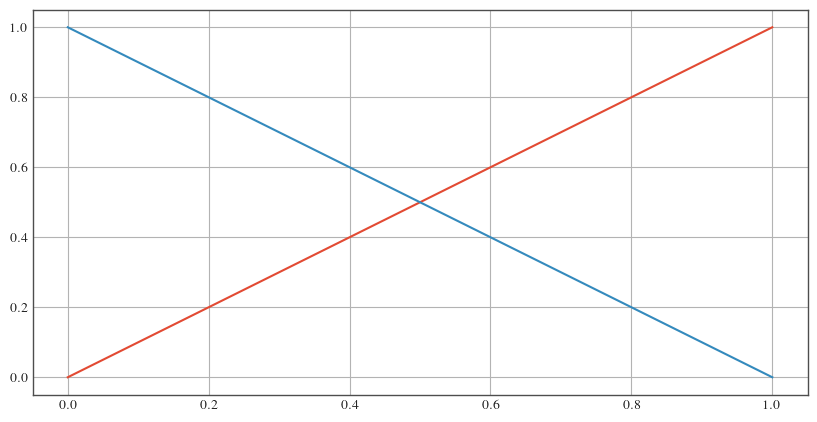

In [2]:
# def f(x):
#     val = np.cos(x*2*np.pi)+1
#     val = val / 2
#     return val
def f(x):
    return x

rel_px = np.linspace(0, 1, 101)
plt.plot(rel_px, f(rel_px))
plt.plot(rel_px, 1-f(rel_px))

gt_f = lambda x: np.max(np.stack((f(x), 1-f(x))), axis=0)
def local_opt_f(x):
    mask = x > 0.5
    out = np.stack((f(x), 1-f(x)))
    out[0, mask] = 0
    return np.max(out, axis=0)

# plt.plot(rel_px, gt_f(rel_px))
print('Best possible Acc:', np.trapz(gt_f(rel_px)))
print('Local optimum Acc:', np.trapz(local_opt_f(rel_px)))

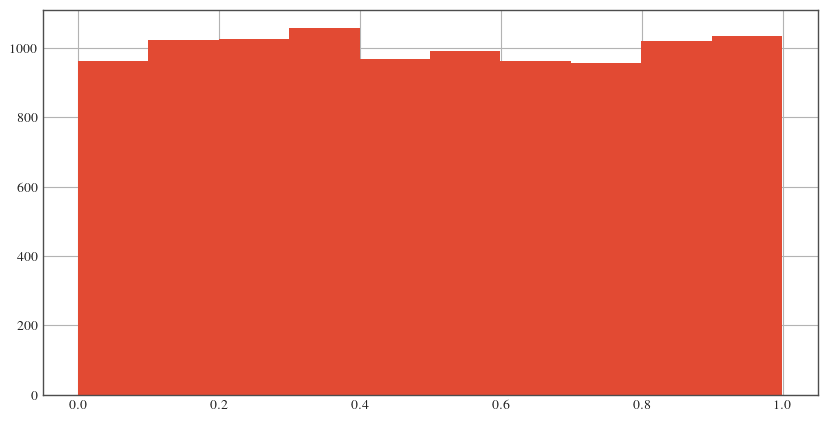

In [3]:
def create_aleatoric_data(n_samples=10_000, img_shape=(3, 32, 32), random_state=None):
    torch.manual_seed(random_state)

    all_imgs = []
    all_targets = []

    # Create a dataset in which the sum of pixels corresponds to the true probability of the label = 1
    n_pixel = np.prod(img_shape)

    for i_sample in range(n_samples):
        img = torch.zeros(n_pixel)

        # Get a random number of pixels to set to one
        n_pixel_to_one = torch.randint(high=n_pixel, size=(1,)).item()
        # Get random positions that should be set to one
        rnd_idx = torch.randperm(n_pixel)[:n_pixel_to_one]
        img[rnd_idx] = 1

        img = img.view(img_shape)
        proba = n_pixel_to_one/n_pixel
        proba = f(proba)
        label = torch.empty(1).bernoulli_(proba).long()

        all_imgs.append(img)
        all_targets.append(label)

    instances = torch.stack(all_imgs).float()
    targets = torch.cat(all_targets).long()
    return instances, targets


from torchvision.transforms import Normalize

instances, targets = create_aleatoric_data(random_state=42)
# mean = instances.mean(dim=(0, 2, 3))
# std = instances.std(dim=(0, 2, 3))
# instances  = Normalize(mean=mean, std=std)(instances)

# torch.save({'instances': instances, 'targets': targets}, './synthetic_images/pixel_sum_dataset.pth')
dataset = torch.utils.data.TensorDataset(instances, targets)

plt.hist(instances.mean(dim=(1, 2, 3)))
plt.show()

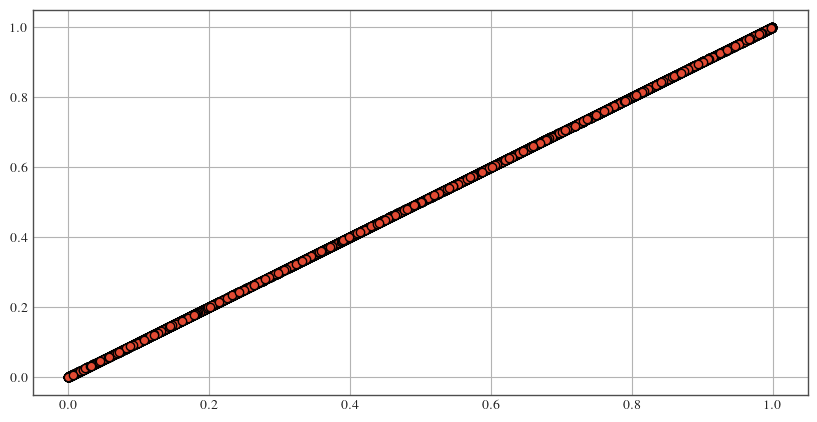

In [4]:
pixel_sums = instances.mean(dim=(1, 2, 3))
gt_probs = f(pixel_sums)
plt.scatter(pixel_sums, gt_probs)
plt.show()

tensor(0.9473)


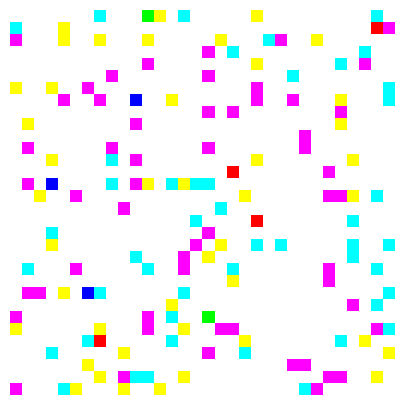

tensor(0.5352)


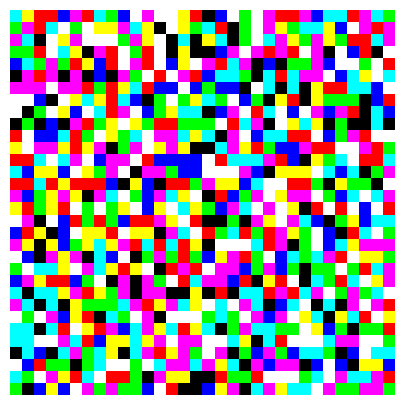

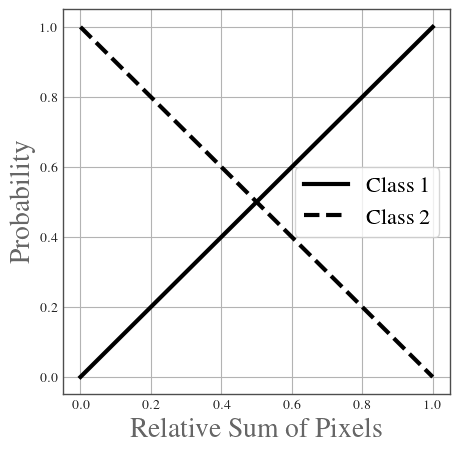

In [5]:
plt.figure(figsize=(5, 5))
rel_pixel_sum = instances.mean(dim=(1, 2, 3))
gt_probas = f(rel_pixel_sum)

img = instances[gt_probas > .9][-2]

print(img.mean())
plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/high_proba_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
img = instances[(gt_probas > .45) & (gt_probas < .55)][0]
print(img.mean())
plt.imshow(img.permute(1, 2, 0))
plt.grid()
plt.axis('off')
plt.savefig('./synthetic_images/aleatoric_instance.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

plt.figure(figsize=(5, 5))
axis = np.linspace(0, 1, 101)
plt.plot(axis, f(axis), linewidth=3, color='k', label='Class 1')
plt.plot(axis, 1-f(axis), linewidth=3, color='k', linestyle='--', label='Class 2')
plt.xlabel('Relative Sum of Pixels', fontdict={'fontsize': 20})
plt.ylabel('Probability', fontdict={'fontsize': 20})
plt.legend(**{'fontsize': 16})
plt.savefig('./synthetic_images/ds_info.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [44]:
# Check training
import lightning as L
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.models.deterministic.resnet import ResNet18
from dal_toolbox.metrics import Accuracy
from dal_toolbox.utils import seed_everything

# Setup data
seed_everything(1)
n_train_samples = int(len(dataset)*.7)
rnd_indices = np.random.permutation(len(dataset))
train_indices = rnd_indices[:n_train_samples]
test_indices = rnd_indices[n_train_samples:]
train_ds = torch.utils.data.Subset(dataset, indices=train_indices[:])
test_ds = torch.utils.data.Subset(dataset, indices=test_indices)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

# Setup model
n_epochs = 200
model = ResNet18(num_classes=2)
optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=.9, weight_decay=0.005)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
model = DeterministicModel(model, loss_fn=criterion, optimizer=optimizer, lr_scheduler=lr_scheduler, train_metrics={'train_acc': Accuracy()})

trainer = L.Trainer(
    enable_checkpointing=False,
    max_epochs=n_epochs,
    logger=False,
)
trainer.fit(model, train_loader)

predcitions = trainer.predict(model, test_loader)
logits = torch.cat([pred[0] for pred in predcitions])
targets = torch.cat([pred[1] for pred in predcitions])
print('Accuracy: ', Accuracy()(logits, targets))

Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | ResNet18         | 11.2 M
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.679    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/219 [00:00<?, ?it/s] 

Epoch 13:   4%|▍         | 9/219 [00:00<00:03, 62.21it/s, train_loss=0.426, train_acc=0.812]  

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 42.39it/s]
Accuracy:  tensor(0.7170)


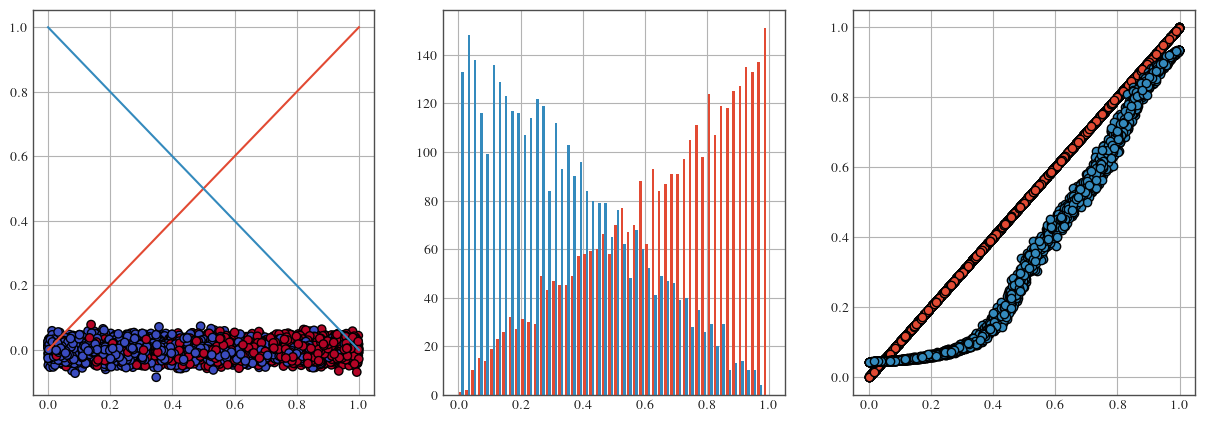

In [45]:
# Plot Samples
rel_pixel_sums, labels = [], []
for x, y in train_ds:
    rel_pixel_sums.append(x.mean())
    labels.append(y)
rel_pixel_sums = torch.stack(rel_pixel_sums)
labels = torch.stack(labels)

fig = plt.figure(figsize=(15, 5))
rel_px = np.linspace(0, 1, 101)
ax = plt.subplot(131)
plt.plot(rel_px, f(rel_px))
plt.plot(rel_px, 1-f(rel_px))
plt.scatter(rel_pixel_sums, torch.zeros_like(rel_pixel_sums)+torch.randn_like(rel_pixel_sums)*.02, c=labels)

plt.subplot(132, sharex=ax)
plt.hist([rel_pixel_sums[labels==1], rel_pixel_sums[labels==0]], bins=50)

plt.subplot(133)
torch.set_grad_enabled(False)
model.eval()

logits_list = []
rel_pixel_sums_list = []
for batch in test_loader:
    logits = model(batch[0])
    px_sum = batch[0].mean(dim=(1, 2, 3))

    logits_list.append(logits)
    rel_pixel_sums_list.append(px_sum)

rel_pixel_sums = torch.cat(rel_pixel_sums_list)
gt_probas = f(rel_pixel_sums)
logits = torch.cat(logits_list)
predicted_probas = logits.softmax(-1)[:, 1]

plt.scatter(rel_pixel_sums, gt_probas, label='gt')
plt.scatter(rel_pixel_sums, predicted_probas, label='predictions')
torch.set_grad_enabled(True)

plt.show()